# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

Solutions Provided by:

**Homework Group A - Team 6**
* Austin Galm
* Timothee Maret
* James Chen
* Michael D'Angelo
* Edward Lin

***

# Importing Libraries

In [1]:
import os
import sys
import pandas as pd
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8-whitegrid")
pd.options.display.float_format = "{:.4f}".format
p = plt.rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Helper Functions

In [2]:
def calc_ewma_volatility(
        excess_returns: pd.Series,
        theta : float = 0.94,
        initial_vol : float = .2 / np.sqrt(252)
    ) -> pd.Series:
    var_t0 = initial_vol ** 2
    ewma_var = [var_t0]
    for i in range(len(excess_returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (excess_returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=excess_returns.index)

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

In [3]:
rets = pd.read_excel('../data/spy_data.xlsx', sheet_name='total returns', parse_dates=True, index_col='date')
rets.index = pd.to_datetime(rets.index)
rets['excess_ret'] = rets['SPY'] - rets['^IRX']
rets

,SPY,^IRX,excess_ret
date,,,
1994-01-04,0.0040,0.0001,0.0039
1994-01-05,0.0020,0.0001,0.0019
1994-01-06,0.0000,0.0001,-0.0001
1994-01-07,0.0060,0.0001,0.0059
1994-01-10,0.0120,0.0001,0.0118
...,...,...,...
2024-07-29,0.0006,0.0002,0.0004
2024-07-30,-0.0051,0.0002,-0.0053
2024-07-31,0.0163,0.0002,0.0161


***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

In [4]:
initial_offset = len(rets.loc[:'2000-12-29'])
rets['var_hist'] = rets.excess_ret.shift(1).expanding(min_periods=initial_offset).quantile(0.05)
rets['2000-12-25':'2001-01-07']

,SPY,^IRX,excess_ret,var_hist
date,,,,
2000-12-26,0.0107,0.0002,0.0105,NaN
2000-12-27,0.0073,0.0002,0.0071,NaN
2000-12-28,0.0030,0.0002,0.0028,NaN
2000-12-29,-0.0189,0.0002,-0.0192,NaN
2001-01-02,-0.0181,0.0002,-0.0183,-0.0177
2001-01-03,0.0480,0.0002,0.0478,-0.0178
2001-01-04,-0.0108,0.0002,-0.0110,-0.0178
2001-01-05,-0.0326,0.0002,-0.0328,-0.0178


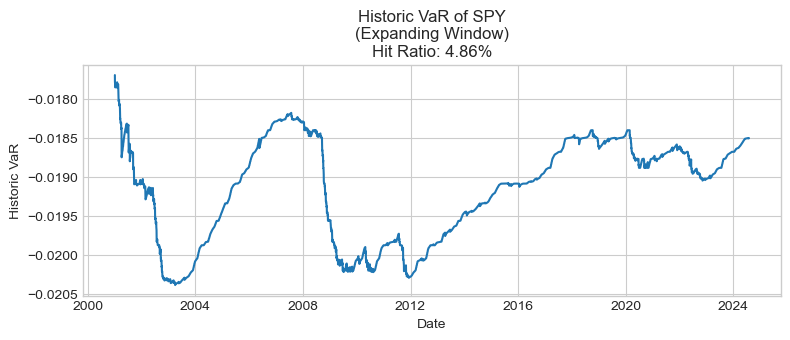

In [5]:
start = '2001-01-02'
var_hist = rets.var_hist[start:]
excess_ret = rets.excess_ret[start:]
hit_ratio = sum(excess_ret < var_hist)/len(var_hist)

fig, ax = plt.subplots(figsize=(9,3))
ax.plot(var_hist.index, var_hist)
ax.set(xlabel='Date',
       ylabel='Historic VaR',
       title=f'Historic VaR of SPY\n(Expanding Window)\nHit Ratio: {hit_ratio:.2%}')
plt.show()

<span style="color:red;">

**Drawbacks of Historic VaR:**
1. *Tail Sensitivity:* Historic VaR will be very sensitive to new data coming into the distribution.


1. *Ghosting Effect:* Equal weights on past observations that may never be realized again.

1. *Slow to React:* The value of VaR does not update continuously with each new observation. Instead, it only updates when new extreme observations come into the distribution, and then these observations have a dramatic effect.

1. *Backward Looking:* Looks only at historical data while estimating losses in the future. Availability of sufficient and relevant data becomes a challenge.

<span>

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

In [6]:
rets['vol_expand'] = np.sqrt((rets.excess_ret**2).shift(1).expanding(initial_offset).mean())
rets['vol_roll'] = np.sqrt((rets.excess_ret**2).shift(1).rolling(252).mean())

vol_ewma = calc_ewma_volatility(excess_returns=excess_ret)
rets['vol_ewma'] = vol_ewma

rets['2000-12-25':'2001-01-07']

,SPY,^IRX,excess_ret,var_hist,vol_expand,vol_roll,vol_ewma
date,,,,,,,
2000-12-26,0.0107,0.0002,0.0105,NaN,NaN,0.0150,NaN
2000-12-27,0.0073,0.0002,0.0071,NaN,NaN,0.0150,NaN
2000-12-28,0.0030,0.0002,0.0028,NaN,NaN,0.0150,NaN
2000-12-29,-0.0189,0.0002,-0.0192,NaN,NaN,0.0150,NaN
2001-01-02,-0.0181,0.0002,-0.0183,-0.0177,0.0111,0.0150,0.0130
2001-01-03,0.0480,0.0002,0.0478,-0.0178,0.0111,0.0151,0.0172
2001-01-04,-0.0108,0.0002,-0.0110,-0.0178,0.0112,0.0152,0.0169
2001-01-05,-0.0326,0.0002,-0.0328,-0.0178,0.0112,0.0152,0.0183


### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

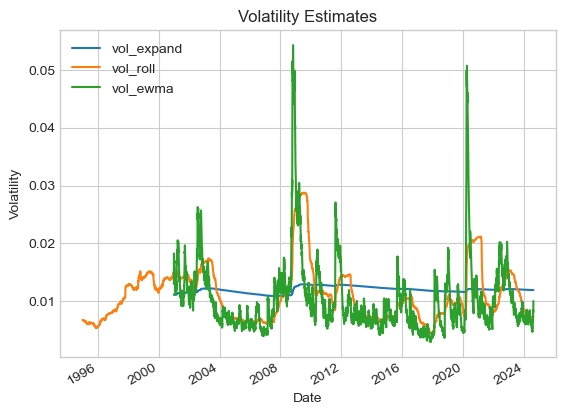

In [7]:
rets[['vol_expand', 'vol_roll', 'vol_ewma']].plot(title='Volatility Estimates', ylabel='Volatility', xlabel='Date')
plt.show()

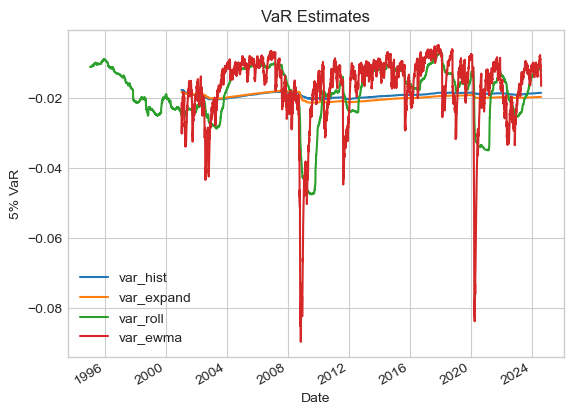

In [8]:
rets['var_expand'] = rets.vol_expand * -1.65
rets['var_roll'] = rets.vol_roll * -1.65
rets['var_ewma'] = rets.vol_ewma * -1.65

rets[['var_hist', 'var_expand', 'var_roll', 'var_ewma']].plot(title='VaR Estimates', 
                                                                ylabel='5% VaR', 
                                                                xlabel='Date')
plt.show()

In [9]:
var_temp = rets[['var_hist', 'var_expand', 'var_roll', 'var_ewma']].dropna()
hit_ratio = var_temp.apply(lambda x: rets['excess_ret'].loc[var_temp.index] < x).mean().to_frame('Hit Ratio')
hit_ratio.style.format('{:,.2%}')

,Hit Ratio
var_hist,4.86%
var_expand,4.61%
var_roll,5.28%
var_ewma,5.08%


<span style="color:red;">

For this daily dataset, which is quite large, each of the VaR measurements is respectable. However, the EWMA measurement proves to be the most accurate, and also is the only one that is relatively conservative! Interestingly, both the expanding window and rolling window approaches perform quite similarly.

<span>

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

In [10]:
rets['cvar_hist_expand'] = rets.excess_ret.shift(1).expanding(initial_offset).apply(lambda x: x[x < x.quantile(0.05)].mean())
rets['cvar_hist_roll'] = rets.excess_ret.shift(1).rolling(252).apply(lambda x: x[x < x.quantile(0.05)].mean())

quantile = 0.05
z_score = norm.ppf(quantile)
rets['cvar_param_expand'] = - norm.pdf(z_score) / quantile * rets['vol_expand']
rets['cvar_param_roll'] = - norm.pdf(z_score) / quantile * rets['vol_roll']
rets['cvar_param_ewma'] = - norm.pdf(z_score) / quantile * rets['vol_ewma']

rets['2000-12-25':'2001-01-07']

,SPY,^IRX,excess_ret,var_hist,vol_expand,vol_roll,vol_ewma,var_expand,var_roll,var_ewma,cvar_hist_expand,cvar_hist_roll,cvar_param_expand,cvar_param_roll,cvar_param_ewma
date,,,,,,,,,,,,,,,
2000-12-26,0.0107,0.0002,0.0105,NaN,NaN,0.0150,NaN,NaN,-0.0247,NaN,NaN,-0.0294,NaN,-0.0309,NaN
2000-12-27,0.0073,0.0002,0.0071,NaN,NaN,0.0150,NaN,NaN,-0.0247,NaN,NaN,-0.0294,NaN,-0.0309,NaN
2000-12-28,0.0030,0.0002,0.0028,NaN,NaN,0.0150,NaN,NaN,-0.0247,NaN,NaN,-0.0294,NaN,-0.0309,NaN
2000-12-29,-0.0189,0.0002,-0.0192,NaN,NaN,0.0150,NaN,NaN,-0.0247,NaN,NaN,-0.0294,NaN,-0.0309,NaN
2001-01-02,-0.0181,0.0002,-0.0183,-0.0177,0.0111,0.0150,0.0130,-0.0183,-0.0248,-0.0215,-0.0252,-0.0294,-0.0229,-0.0310,-0.0268
2001-01-03,0.0480,0.0002,0.0478,-0.0178,0.0111,0.0151,0.0172,-0.0183,-0.0249,-0.0284,-0.0252,-0.0294,-0.0229,-0.0311,-0.0355
2001-01-04,-0.0108,0.0002,-0.0110,-0.0178,0.0112,0.0152,0.0169,-0.0184,-0.0250,-0.0279,-0.0252,-0.0282,-0.0230,-0.0313,-0.0349
2001-01-05,-0.0326,0.0002,-0.0328,-0.0178,0.0112,0.0152,0.0183,-0.0184,-0.0250,-0.0301,-0.0252,-0.0282,-0.0230,-0.0313,-0.0377


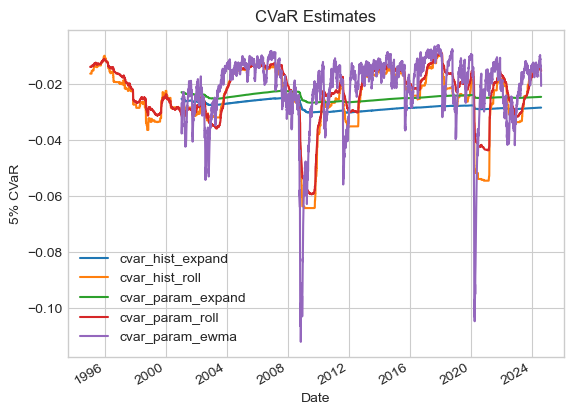

In [11]:
cvar = rets[['cvar_hist_expand', 'cvar_hist_roll', 'cvar_param_expand', 'cvar_param_roll', 'cvar_param_ewma']]
cvar.plot(title='CVaR Estimates', ylabel='5% CVaR', xlabel='Date')
plt.show()

In [12]:
cvar_temp = rets[['cvar_hist_expand', 'cvar_hist_roll', 'cvar_param_expand', 'cvar_param_roll', 'cvar_param_ewma']].dropna()
hit_ratio = cvar_temp.apply(lambda x: rets['excess_ret'].loc[cvar_temp.index] < x).mean().to_frame('Hit Ratio')
hit_ratio.style.format('{:,.2%}')

,Hit Ratio
cvar_hist_expand,1.96%
cvar_hist_roll,2.60%
cvar_param_expand,2.51%
cvar_param_roll,3.31%
cvar_param_ewma,2.13%


***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.